In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

In [2]:
def lor(f, f0, w, h):
    return h / (1.0 + 4.0 / w**2 * (f - f0)**2)

In [3]:
f = np.linspace(100,120,2000)
true = 1 + lor(f, 110.0, 0.5, 100.0)
data = true * (np.random.chisquare(2, size=len(f))/2)

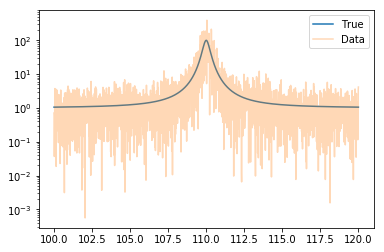

In [4]:
fig, ax = plt.subplots()
ax.plot(f, true, label='True')
ax.plot(f, data, alpha=0.3, label='Data')
ax.legend()
ax.set_yscale('log')

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0.001, 1)

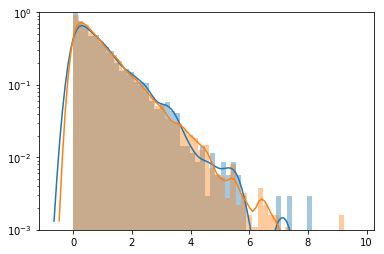

In [5]:
fig, ax = plt.subplots()
sns.distplot(data / true, ax=ax)
sns.distplot(np.random.chisquare(2, 10000)/2, ax=ax)
ax.set_yscale('log')
ax.set_ylim(0.001, 1)

In [ ]:
code = '''
functions {
    real lor(real freq, real f0, real w, real h){
        return h / (1.0 + 4.0 / w^2 * (freq - f0)^2);
    }
}
data {
    int N;
    real f[N];
    real snr[N];
}
parameters {
    real freq;
    real ln_width;
    real ln_height;
}
transformed parameters {
    real width;
    real height;
    width = exp(ln_width);
    height = exp(ln_height);
}
model {
    real beta[N];
    for (i in 1:N){
        beta[i] = 1.0 / (1.0 + lor(f[i], freq, width, height));
    }
    snr ~ gamma(1, beta);
    freq ~ normal(110.0, 1.0);
    ln_width ~ normal(log(0.5), 0.3);
    ln_height ~ normal(log(100.0), 0.3);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_71b528cf39c93eb6fe3973cfbb67800a NOW.


In [7]:
stan_data = {'N': len(f),
             'f': f, 
             'snr': data}
start = {'freq': 110.0}
nchains = 4
fit = sm.sampling(data=stan_data, iter=1000, chains=nchains, init=[start for n in range(nchains)])

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
print(fit)

Inference for Stan model: anon_model_71b528cf39c93eb6fe3973cfbb67800a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
freq      110.01  7.0e-4   0.02 109.97  110.0 110.01 110.03 110.06   1020   1.01
ln_width    -0.7  3.2e-3   0.09  -0.88  -0.76   -0.7  -0.64  -0.55    731   1.01
ln_height   4.65  5.6e-3   0.15   4.39   4.55   4.64   4.75   4.96    730    1.0
width        0.5  1.6e-3   0.04   0.41   0.47    0.5   0.53   0.58    744    1.0
height     105.8    0.61  16.26  80.43  94.17 103.83 116.08 142.74    702   1.01
lp__       -3304    0.05   1.29  -3308  -3305  -3304  -3303  -3303    571   1.01

Samples were drawn using NUTS at Thu Nov  1 16:32:07 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


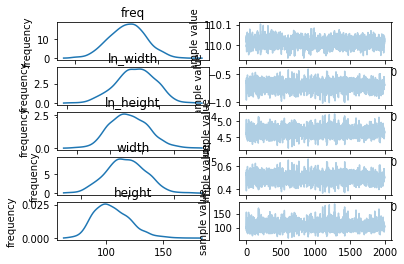

In [9]:
fit.plot()
plt.show()